# Advanced Deep Learning Framework for Brain Tumor Diagnosis and Classification

This advanced deep learning framework for brain tumor diagnosis and classification employs state-of-the-art pretrained models to accurately classify brain tumors into four distinct categories: Pituitary, Glioma, Meningioma, and No Tumor. By leveraging pretrained models such as InceptionV3,VGG16, ResNet101, and InceptionResNetV2, the framework is able to efficiently learn and extract meaningful features from brain tumor images, enhancing diagnostic accuracy. Through rigorous evaluation and comparison, the framework identifies the most effective model for the task, providing medical professionals with a powerful tool for improved patient care and medical image analysis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow
from PIL import Image
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, save_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization,Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation,GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adamax
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
from sklearn.model_selection import StratifiedKFold
import random
from tensorflow.keras import layers

In [2]:
import os
import cv2

def check_images(dataset_path):
    missing_images = []
    corrupted_images = []

    # Iterate through the dataset directory
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            image_path = os.path.join(root, file)
            
            # Try to read the image using OpenCV
            try:
                img = cv2.imread(image_path)
                if img is None:
                    missing_images.append(image_path)
                elif img.size == 0:
                    corrupted_images.append(image_path)
            except Exception as e:
                corrupted_images.append(image_path)
            except Exception as e:
                print("Error reading image:", e)
                corrupted_images.append(image_path)

    
    return missing_images, corrupted_images

# Example usage
dataset_path = "/content/drive/MyDrive/BrainTumor/Training"
missing_images, corrupted_images = check_images(dataset_path)

# Handle missing images
if missing_images:
    print("Missing images:")
    for image_path in missing_images:
        print(image_path)

# Handle corrupted images
if corrupted_images:
    print("Corrupted images:")
    for image_path in corrupted_images:
        print(image_path)


In [3]:
train_data_dir = 'C:\\Users\Venkatesh\Downloads\BrainTumor\Training'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
# print(folds)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

train_df = pd.concat([Fseries, Lseries], axis= 1)
train_df



filepaths     labels
0     C:\Users\Venkatesh\Downloads\BrainTumor\Traini...     glioma
1     C:\Users\Venkatesh\Downloads\BrainTumor\Traini...     glioma
2     C:\Users\Venkatesh\Downloads\BrainTumor\Traini...     glioma
3     C:\Users\Venkatesh\Downloads\BrainTumor\Traini...     glioma
4     C:\Users\Venkatesh\Downloads\BrainTumor\Traini...     glioma
...                                                 ...        ...
5707  C:\Users\Venkatesh\Downloads\BrainTumor\Traini...  pituitary
5708  C:\Users\Venkatesh\Downloads\BrainTumor\Traini...  pituitary
5709  C:\Users\Venkatesh\Downloads\BrainTumor\Traini...  pituitary
5710  C:\Users\Venkatesh\Downloads\BrainTumor\Traini...  pituitary
5711  C:\Users\Venkatesh\Downloads\BrainTumor\Traini...  pituitary

[5712 rows x 2 columns]

In [4]:
# Generate data paths with labels
test_data_dir = 'C:\\Users\Venkatesh\Downloads\BrainTumor\Testing'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)
test_df


filepaths     labels
0     C:\Users\Venkatesh\Downloads\BrainTumor\Testin...     glioma
1     C:\Users\Venkatesh\Downloads\BrainTumor\Testin...     glioma
2     C:\Users\Venkatesh\Downloads\BrainTumor\Testin...     glioma
3     C:\Users\Venkatesh\Downloads\BrainTumor\Testin...     glioma
4     C:\Users\Venkatesh\Downloads\BrainTumor\Testin...     glioma
...                                                 ...        ...
1306  C:\Users\Venkatesh\Downloads\BrainTumor\Testin...  pituitary
1307  C:\Users\Venkatesh\Downloads\BrainTumor\Testin...  pituitary
1308  C:\Users\Venkatesh\Downloads\BrainTumor\Testin...  pituitary
1309  C:\Users\Venkatesh\Downloads\BrainTumor\Testin...  pituitary
1310  C:\Users\Venkatesh\Downloads\BrainTumor\Testin...  pituitary

[1311 rows x 2 columns]

In [5]:
class_names = train_df['labels'].unique()
#class_names = ", ".join(class_names)
print(class_names)


['glioma' 'meningioma' 'notumor' 'pituitary']


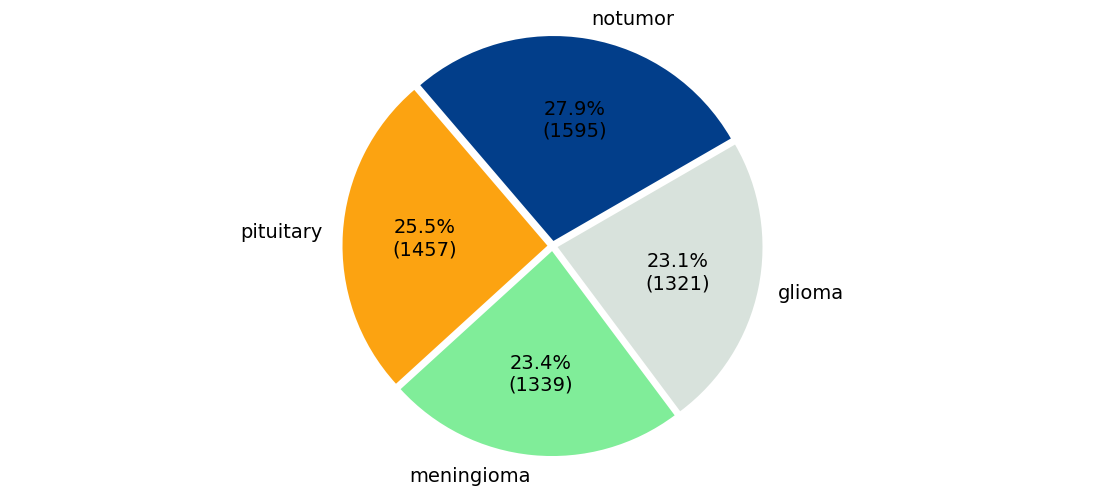

In [6]:
#Graph Dataset Split
plt.figure(figsize = (14, 6))
plt.rcParams.update({'font.size': 14})
data_balance = train_df.labels.value_counts()

def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct * total / 100.0))
    return "{:.1f}%\n({:d})".format(pct, val)

plt.pie(data_balance,
        labels = data_balance.index,
        autopct = custom_autopct,
        colors = ['#023e8a', '#fca311', '#80ed99', '#d8e2dc'],
        explode = (0.025, 0.025, 0.025, 0.025),
        startangle = 30);
plt.axis('equal')
plt.show()

(5712, 2)


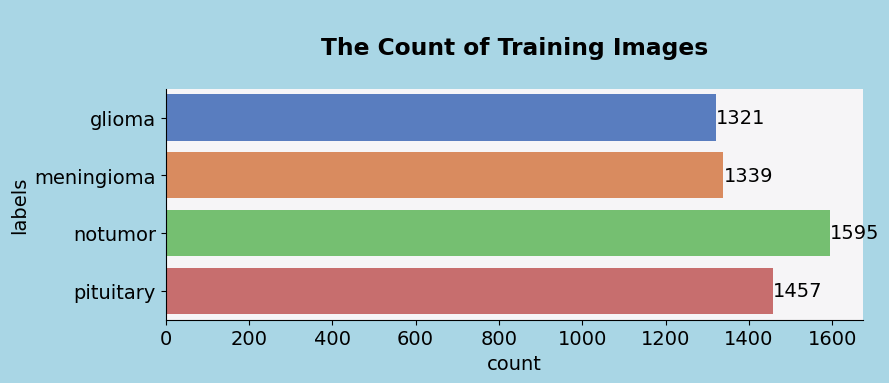

In [7]:
fig, ax = plt.subplots(figsize=(9, 3))
fig.patch.set_facecolor("#a9d6e5")
ax.set_facecolor("#f6f5f7")
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

x = sns.countplot(data=train_df, y=train_df["labels"], palette='muted')
for container in x.containers:
    x.bar_label(container)
plt.title("\nThe Count of Training Images\n", weight="bold")
print(train_df.shape)
plt.show()

(1311, 2)


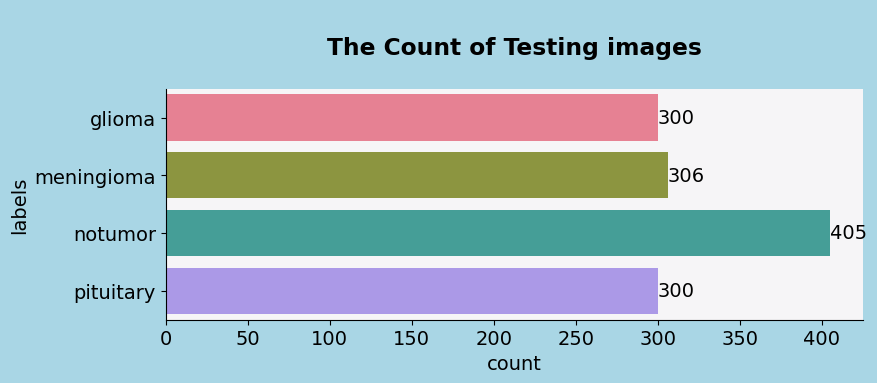

In [8]:
fig,ax=plt.subplots(figsize=(9,3))
fig.patch.set_facecolor("#a9d6e5")
ax.set_facecolor("#f6f5f7")
for i in ["right","top"]:
    ax.spines[i].set_visible(False)
    
i=sns.countplot(data=test_df,y=test_df["labels"],palette='husl')
for container in i.containers:
    i.bar_label(container)
    
plt.title("\nThe Count of Testing images\n",weight="bold");

print(test_df.shape)

In [9]:
#Split dataset
valid_df, test_df = train_test_split(test_df, train_size = 0.5, shuffle = True, random_state = 42)

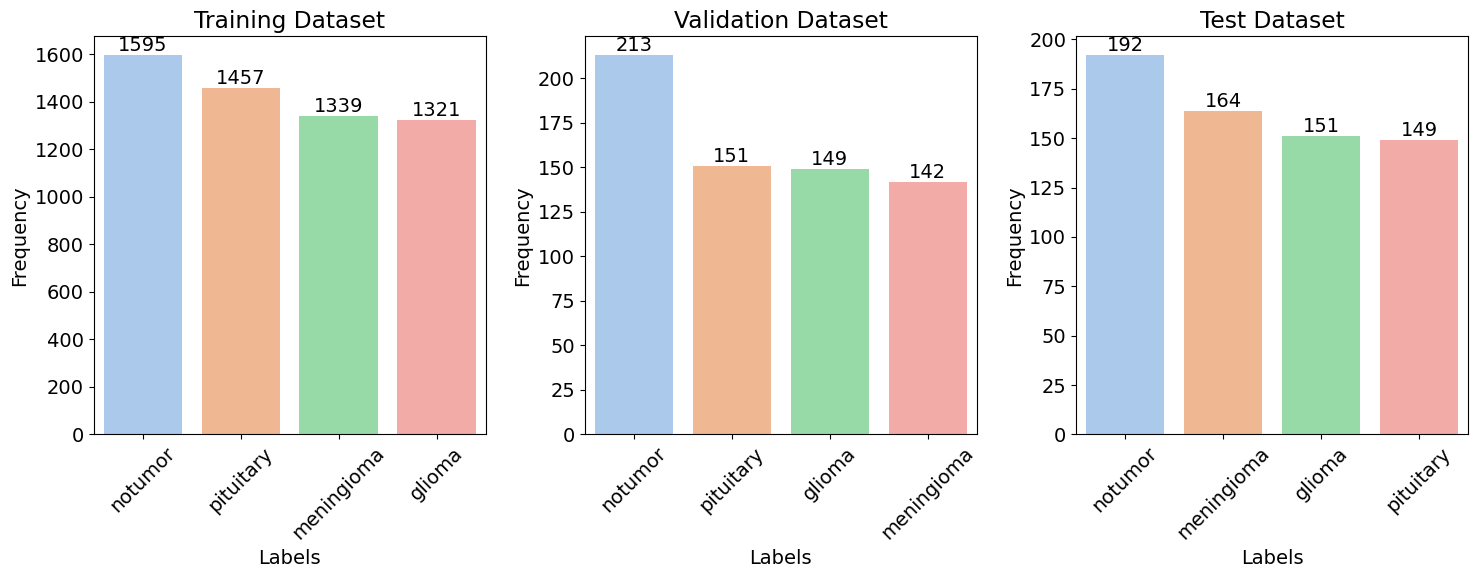

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the color palette
colors = sns.color_palette("pastel")

# Calculate frequency distribution for each dataset
train_label_counts = train_df['labels'].value_counts()
valid_label_counts = valid_df['labels'].value_counts()
test_label_counts = test_df['labels'].value_counts()

# Plot frequency distribution for each dataset
plt.figure(figsize=(15, 6))

# Training dataset
plt.subplot(1, 3, 1)
sns.barplot(x=train_label_counts.index, y=train_label_counts.values, palette=colors)
plt.title('Training Dataset')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
for i, val in enumerate(train_label_counts.values):
    plt.text(i, val, str(val), ha='center', va='bottom')

# Validation dataset
plt.subplot(1, 3, 2)
sns.barplot(x=valid_label_counts.index, y=valid_label_counts.values, palette=colors)
plt.title('Validation Dataset')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
for i, val in enumerate(valid_label_counts.values):
    plt.text(i, val, str(val), ha='center', va='bottom')

# Test dataset
plt.subplot(1, 3, 3)
sns.barplot(x=test_label_counts.index, y=test_label_counts.values, palette=colors)
plt.title('Test Dataset')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
for i, val in enumerate(test_label_counts.values):
    plt.text(i, val, str(val), ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [11]:
# Augment and Preprocess Scans
batch_size = 64
img_size = (224, 224)

# ImageDataGenerator for training data
tr_gen = ImageDataGenerator()

# ImageDataGenerator for validation and testing data
ts_gen = ImageDataGenerator()

# Flow from dataframe for training data
train_gen = tr_gen.flow_from_dataframe(
    train_df,
    rescale=1./255,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    seed=42,
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

# Flow from dataframe for validation data
valid_gen = ts_gen.flow_from_dataframe(
    valid_df,
    rescale=1./255,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    seed=42,
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

# Flow from dataframe for testing data
test_gen = ts_gen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    seed=42,
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)


Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [12]:
batch_data, batch_labels = next(train_gen)
print("Batch data shape:", batch_data.shape)
print("Batch labels shape:", batch_labels.shape)

Batch data shape: (64, 224, 224, 3)
Batch labels shape: (64, 4)


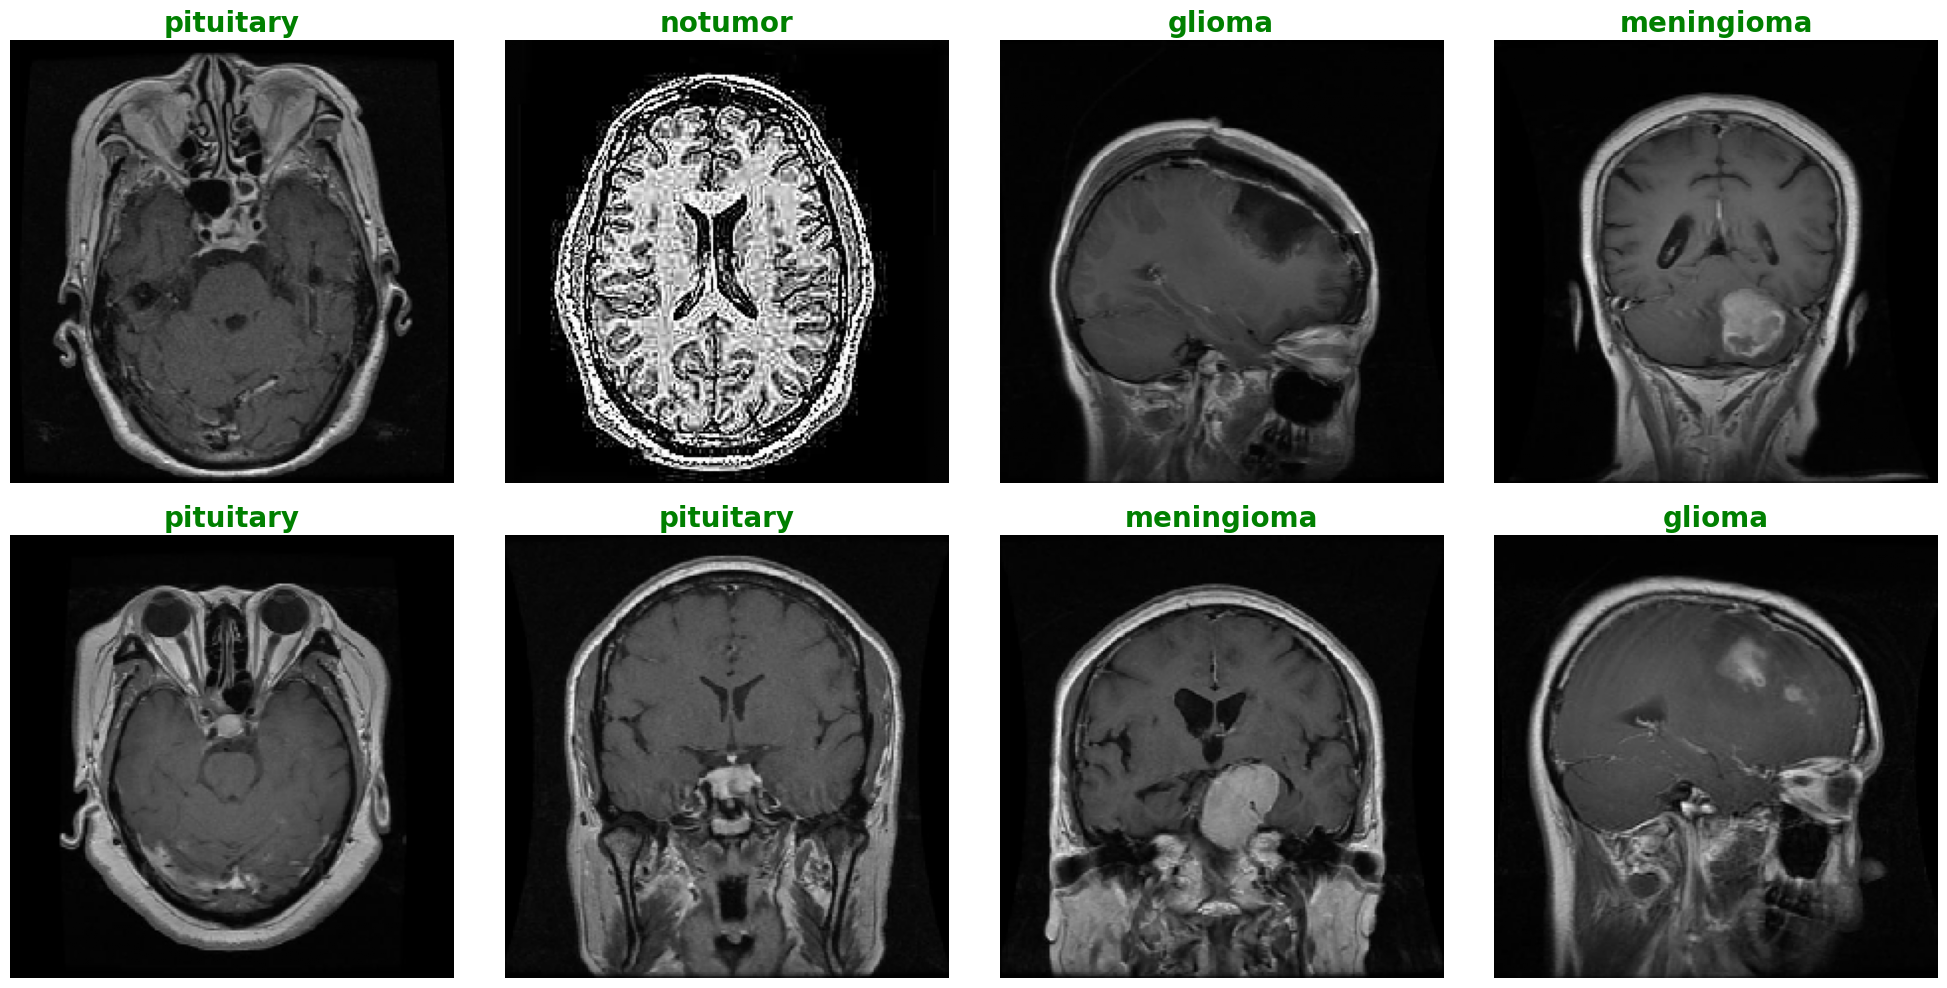

In [13]:
g_dict = train_gen.class_indices     
classes = list(g_dict.keys())       
images, labels = next(train_gen) 


plt.figure(figsize= (20, 20))

for i in range(8):
    plt.subplot(4, 4, i + 1)
    image = images[i].astype("uint8") / 255       
    plt.imshow(image)
    index = np.argmax(labels[i]) 
    class_name = classes[index]   
    plt.title(class_name, color= 'green', fontsize= 20, weight="bold")
    plt.axis('off')
plt.tight_layout()
plt.show()

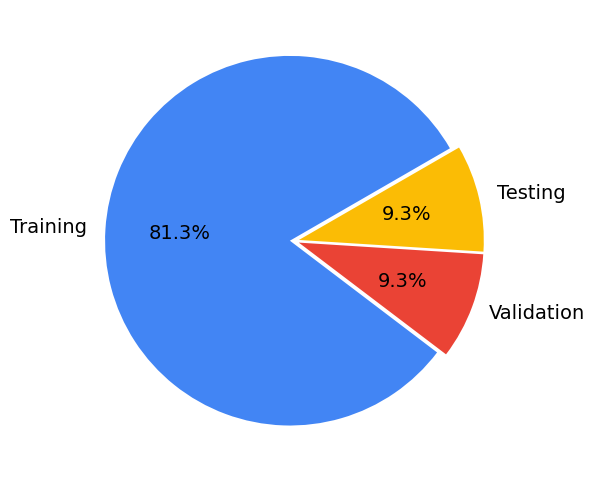

In [14]:
#Graph Dataset Directories
plt.figure(figsize = (14, 6))
plt.rcParams.update({'font.size': 14})

plt.pie([len(train_df), len(valid_df), len(test_df)],
        labels = ['Training','Validation', 'Testing'],
        colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853'], 
        autopct = '%.1f%%', 
        explode = (0.025, 0.025, 0.025),
        startangle = 30);

## InceptionResnetV2

In [64]:
from keras.applications import InceptionResNetV2

img_rows, img_cols = 224,224

# Load InceptionResNetV2 model without the top (fully connected) layers
inception_resnet = InceptionResNetV2(weights='imagenet', 
                                     include_top=False, 
                                     input_shape=(img_rows, img_cols, 3))

# Freeze all layers in InceptionResNetV2
for layer in inception_resnet.layers:
    layer.trainable = False

# Define custom head for the model
def build_custom_head(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = Dense(128, activation='relu')(top_model)
    top_model = Dense(num_classes, activation='softmax')(top_model)
    return top_model


num_classes = 4 

FC_Head = build_custom_head(inception_resnet, num_classes)

model1 = Model(inputs=inception_resnet.input, outputs=FC_Head)

# Print model summary
print(model1.summary())



219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 32s 0us/step


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_107 (Conv2D)           │ (None, 111, 111, 32)      │             864 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_94        │ (None, 111, 111, 32)      │              96 │ conv2d_107[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_94 (Activation)    │ (None, 111, 111, 32)      │               0 │ batch_normalization_94[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_108 (Conv2D)           │ (None, 109, 109, 32)      │           9,216 │ activation_94[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_95        │ (None, 109, 109, 32)      │              96 │ conv2d_108[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_95 (Activation)    │ (None, 109, 109, 32)      │               0 │ batch_normalization_95[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_109 (Conv2D)           │ (None, 109, 109, 64)      │          18,432 │ activation_95[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_96        │ (None, 109, 109, 64)      │             192 │ conv2d_109[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_96 (Activation)    │ (None, 109, 109, 64)      │               0 │ batch_normalization_96[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_9               │ (None, 54, 54, 64)        │               0 │ activation_96[0][0]        │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_110 (Conv2D)           │ (None, 54, 54, 80)        │           5,120 │ max_pooling2d_9[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_97        │ (None, 54, 54, 80)        │             240 │ conv2d_110[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_97 (Activation)    │ (None, 54, 54, 80)        │               0 │ batch_normalization_97[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_111 (Conv2D)           │ (None, 52, 52, 192)       │         138,24

 Total params: 56,501,604 (215.54 MB)

 Trainable params: 2,164,868 (8.26 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

None


In [65]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss',  
                               patience=3,          # Number of epochs with no improvement after which training will be stopped
                               restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
                               verbose=1)  

model1.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy']
                   )

history = model1.fit(train_gen, epochs=30, validation_data=valid_gen,callbacks=early_stopping)

Epoch 1/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 404s 4s/step - accuracy: 0.2742 - loss: 119.2429 - val_accuracy: 0.2305 - val_loss: 14.4778
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 373s 4s/step - accuracy: 0.3587 - loss: 4.5105 - val_accuracy: 0.4153 - val_loss: 1.8124
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 379s 4s/step - accuracy: 0.4054 - loss: 1.9166 - val_accuracy: 0.4015 - val_loss: 1.9466
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 386s 4s/step - accuracy: 0.4513 - loss: 1.5938 - val_accuracy: 0.4962 - val_loss: 1.2425
Epoch 5/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 455s 5s/step - accuracy: 0.5129 - loss: 1.1238 - val_accuracy: 0.4870 - val_loss: 1.3283
Epoch 6/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 391s 4s/step - accuracy: 0.5119 - loss: 1.0975 - val_accuracy: 0.5389 - val_loss: 1.0811
Epoch 7/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 363s 4s/step - accuracy: 0.5369 - loss: 1.0665 - val_accuracy: 0.5542 - val_loss: 1.0460
Epoch 8/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 362s 4s/step - accuracy: 0.5545 - loss: 1.0537 - val_accuracy: 0.5206 

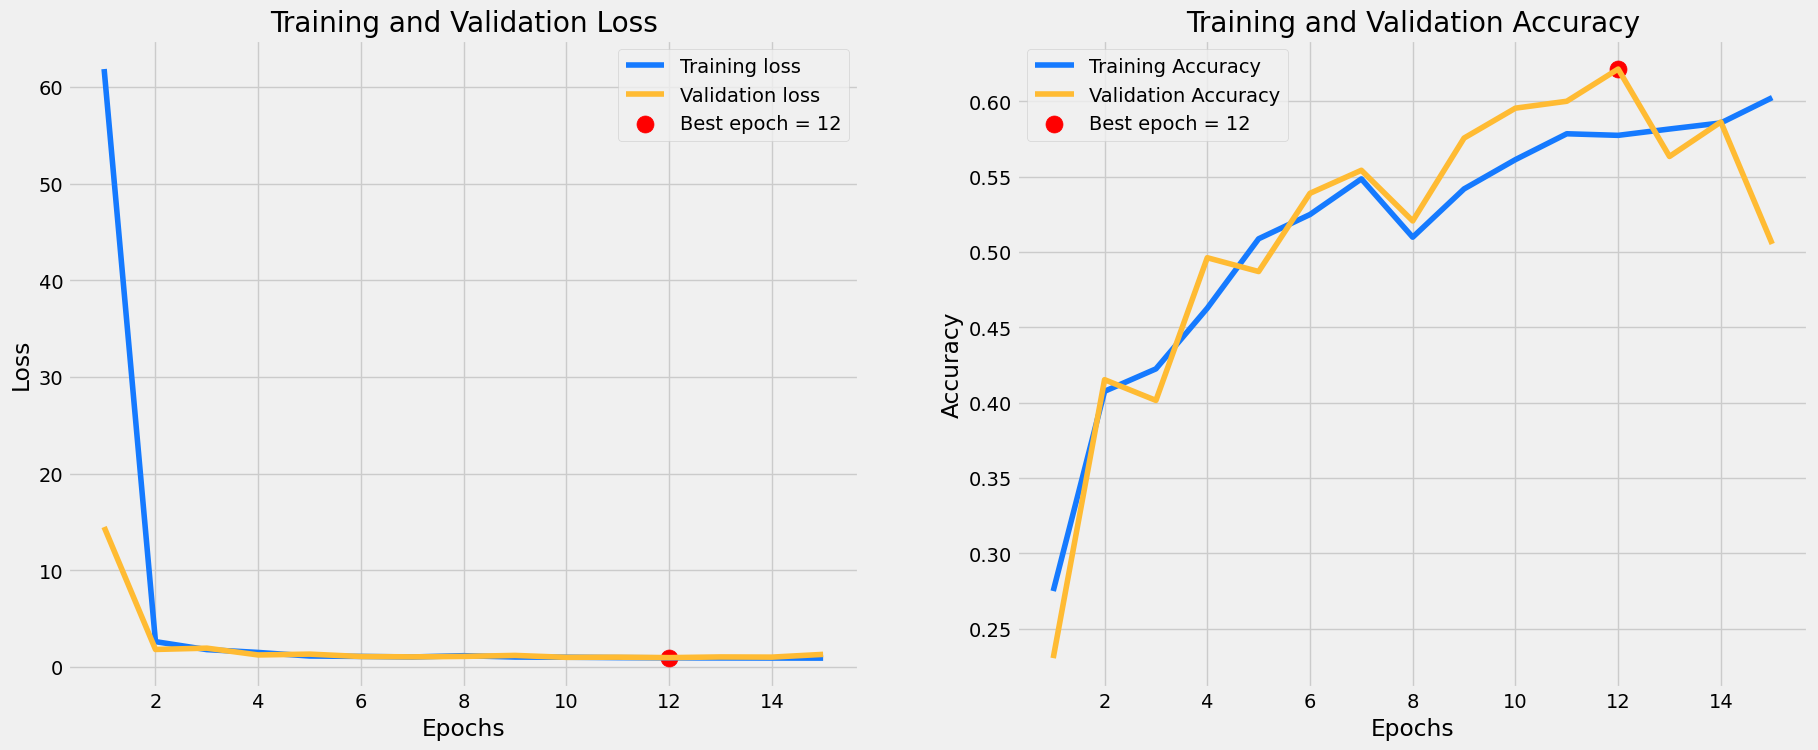

In [66]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'

plt.figure(figsize = (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, color = '#157AFF', label = 'Training loss')
plt.plot(Epochs, val_loss, color = '#FFBB33', label = 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s = 150, color = 'red', label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, color = '#157AFF', label = 'Training Accuracy')
plt.plot(Epochs, val_acc, color = '#FFBB33', label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s = 150, color = 'red', label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [68]:
loss,acc = model1.evaluate(test_gen)

11/11 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.6119 - loss: 1.0101


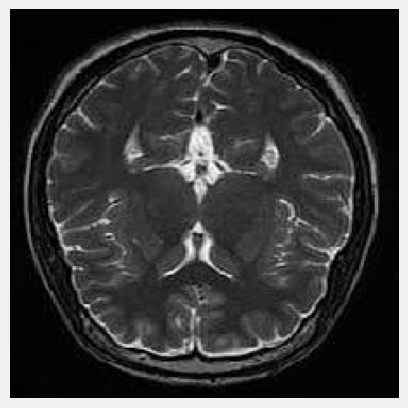

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predicted label: notumor | Actual label: notumor


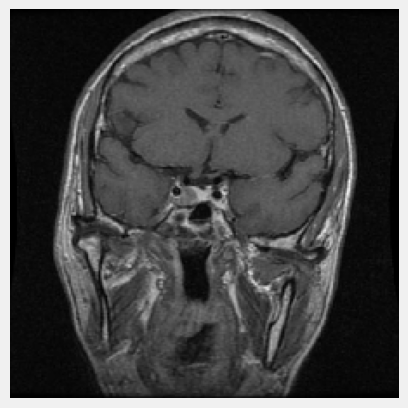

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Predicted label: pituitary | Actual label: pituitary


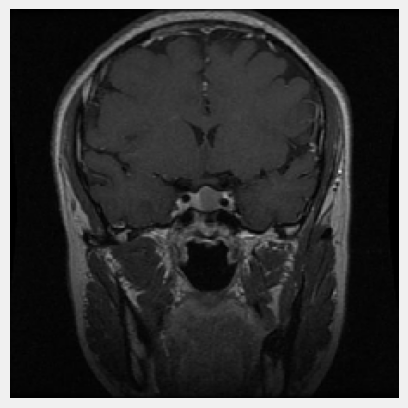

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
Predicted label: pituitary | Actual label: pituitary


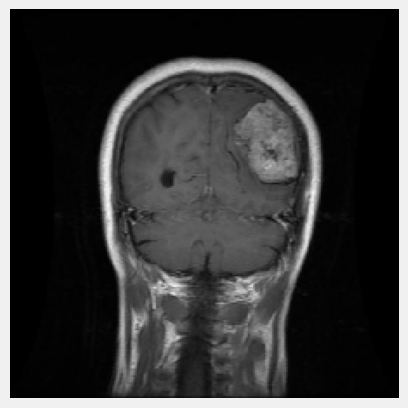

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Predicted label: glioma | Actual label: meningioma


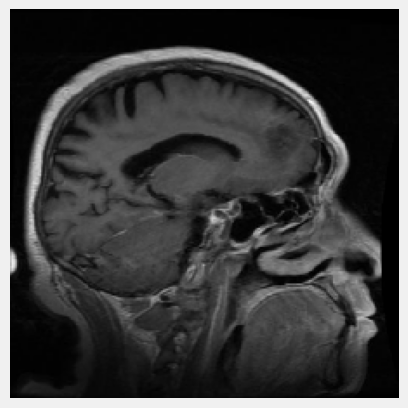

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Predicted label: glioma | Actual label: glioma


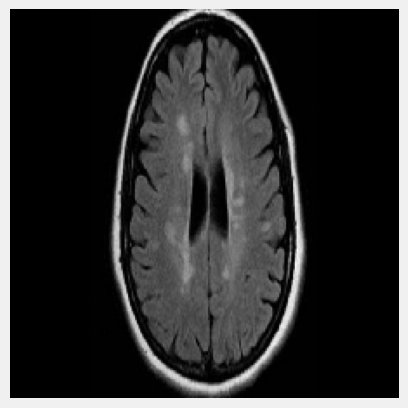

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Predicted label: notumor | Actual label: notumor


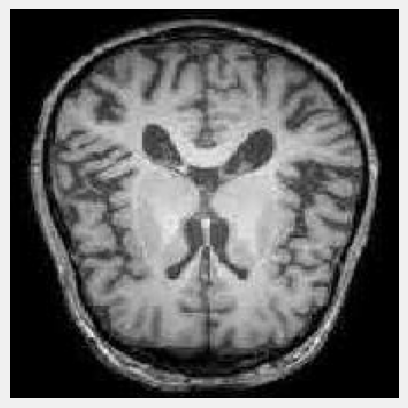

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Predicted label: notumor | Actual label: notumor


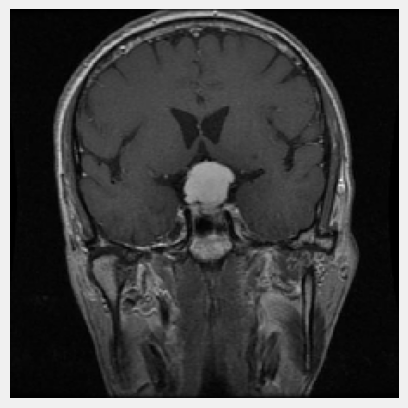

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Predicted label: pituitary | Actual label: meningioma


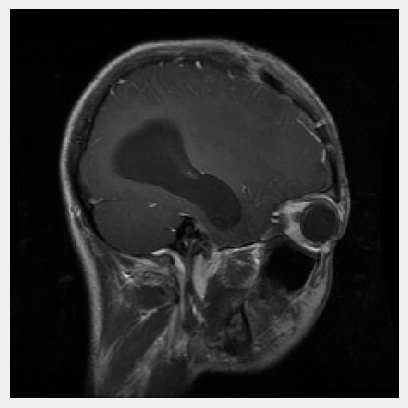

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Predicted label: glioma | Actual label: glioma


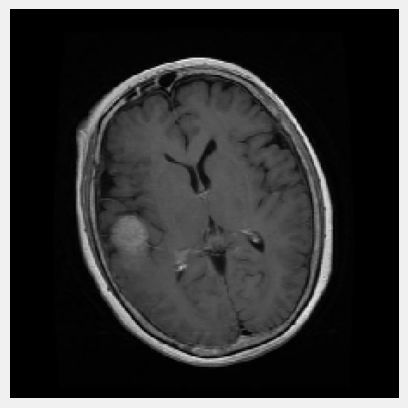

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Predicted label: glioma | Actual label: meningioma


In [70]:
image, labels = next(test_gen)

for i in range(10):
    plt.imshow(image[i].astype('uint8'))  # Ensure the image is in uint8 format
    plt.axis('off')  # Turn off axis
    plt.show()  # Display the image
    
    prediction = np.argmax(model1.predict(image[i][np.newaxis, ...]))
    actual_label_index = np.argmax(labels[i])  # Convert one-hot encoded label to index
    print(f"Predicted label: {class_names[prediction]} | Actual label: {class_names[actual_label_index]}")


In [74]:
# Results for Model 1: training, validating, testing
print("Model 1:")
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


Model 1:
Train Loss:  0.8842359185218811
Train Accuracy:  0.6300770044326782
--------------------
Validation Loss:  0.9658582210540771
Validation Accuracy:  0.6213740706443787
--------------------
Test Loss:  1.0309573411941528
Test Accuracy:  0.5960366129875183


11/11 ━━━━━━━━━━━━━━━━━━━━ 55s 5s/step


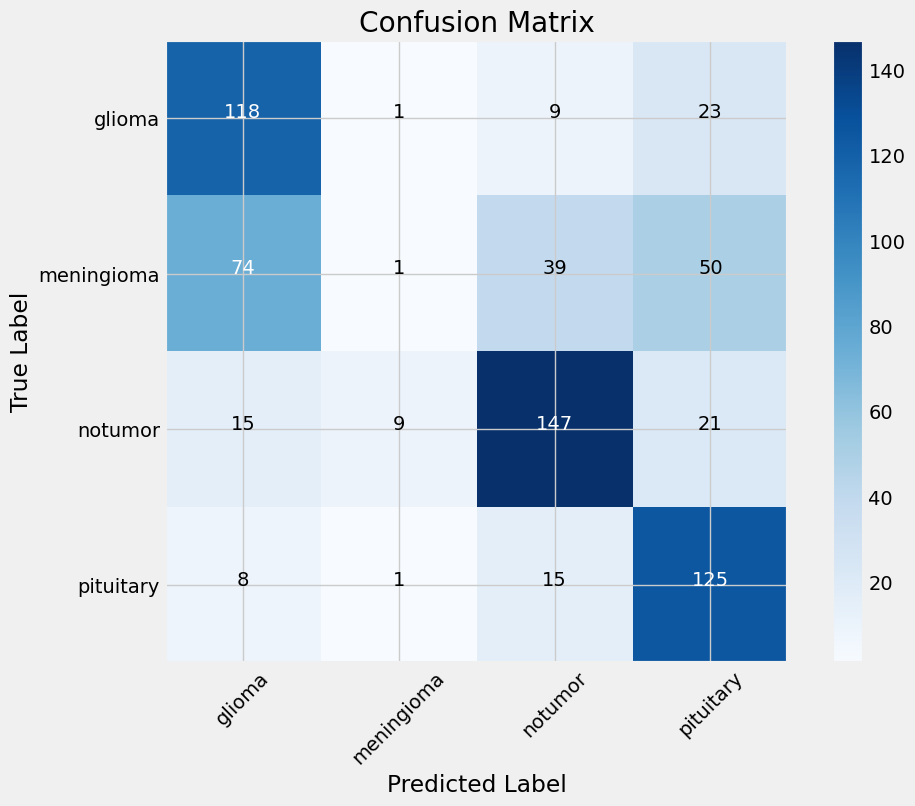

In [76]:
import itertools

# Generate predictions for the test data
predictions = model1.predict(test_gen)

class_names = list(test_gen.class_indices.keys())
images, labels = next(test_gen)

# Extract the predicted labels from the predictions
predicted_labels = np.argmax(predictions, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(test_gen.classes, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [94]:
y_true_model1 = test_gen.classes
y_pred1 = model1.predict(test_gen)

# Print the classification report
print(classification_report(y_true_model1, np.argmax(y_pred1, axis=1), target_names=classes))


11/11 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step
              precision    recall  f1-score   support

      glioma       0.55      0.78      0.64       151
  meningioma       0.08      0.01      0.01       164
     notumor       0.70      0.77      0.73       192
   pituitary       0.57      0.84      0.68       149

    accuracy                           0.60       656
   macro avg       0.48      0.60      0.52       656
weighted avg       0.48      0.60      0.52       656



In [78]:
from keras.preprocessing import image

# Load and preprocess the new image
img_path = 'C:/Users/Venkatesh/Downloads/test02.jpeg'
img = image.load_img(img_path, target_size=(224, 224))  # Resize to match input size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Rescale pixel values

# Make predictions with your trained model
predictions = model1.predict(img_array)

# Interpret predictions
predicted_class = np.argmax(predictions)
class_name = class_names[predicted_class]

print("Predicted Class:", class_name)
print("Predicted Probabilities:", predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
Predicted Class: pituitary
Predicted Probabilities: [[0.22166185 0.18554215 0.1963321  0.39646387]]


## VGG-16

In [15]:
from keras.applications import vgg16
from keras.models import Model

img_rows, img_cols = 224, 224 

# Load VGG16 model without the top (fully connected) layers
vgg = vgg16.VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape=(img_rows, img_cols, 3))

# Freeze all layers in VGG16
for layer in vgg.layers:
    layer.trainable = False

# Define custom head for the model
for (i,layer) in enumerate(vgg.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)
    def build_custom_head(bottom_model, num_classes):
        top_model = bottom_model.output
        top_model = GlobalAveragePooling2D()(top_model)
        top_model = Dense(1024, activation='relu')(top_model)
        top_model = Dense(512, activation='relu')(top_model)
        top_model = Dense(128, activation='relu')(top_model)
        top_model = Dense(num_classes, activation='softmax')(top_model)
        return top_model

# Define number of classes
num_classes = 4  # Change this to the desired number of classes

# Build custom head for the model with 4 output classes
FC_Head = build_custom_head(vgg, num_classes)

model2 = Model(inputs = vgg.input, outputs = FC_Head)

# Create final model
#model = Sequential()
#model.add(vgg)
#model.add(FC_Head)
#model.add(Dense(4, activation='softmax'))

# Print model summary
print(model2.summary())



0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         525,3

 Total params: 15,830,980 (60.39 MB)

 Trainable params: 1,116,292 (4.26 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


### Early stopping

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss',  
                               patience=3,          # Number of epochs with no improvement after which training will be stopped
                               restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
                               verbose=1)  

model2.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy']
                   )

history = model2.fit(train_gen, epochs=30, validation_data=valid_gen,callbacks=early_stopping)

Epoch 1/30


C:\Users\Venkatesh\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 469s 5s/step - accuracy: 0.6897 - loss: 1.2676 - val_accuracy: 0.8733 - val_loss: 0.3334
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 463s 5s/step - accuracy: 0.9066 - loss: 0.2481 - val_accuracy: 0.8916 - val_loss: 0.2377
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 461s 5s/step - accuracy: 0.9332 - loss: 0.1658 - val_accuracy: 0.9023 - val_loss: 0.2379
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 463s 5s/step - accuracy: 0.9547 - loss: 0.1323 - val_accuracy: 0.9405 - val_loss: 0.1400
Epoch 5/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 559s 6s/step - accuracy: 0.9756 - loss: 0.0744 - val_accuracy: 0.9374 - val_loss: 0.1333
Epoch 6/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 25101s 282s/step - accuracy: 0.9791 - loss: 0.0646 - val_accuracy: 0.9649 - val_loss: 0.1007
Epoch 7/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 401s 4s/step - accuracy: 0.9806 - loss: 0.0536 - val_accuracy: 0.9573 - val_loss: 0.1069
Epoch 8/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 403s 4s/step - accuracy: 0.9831 - loss: 0.0503 - val_accuracy: 0.9725 - val_loss

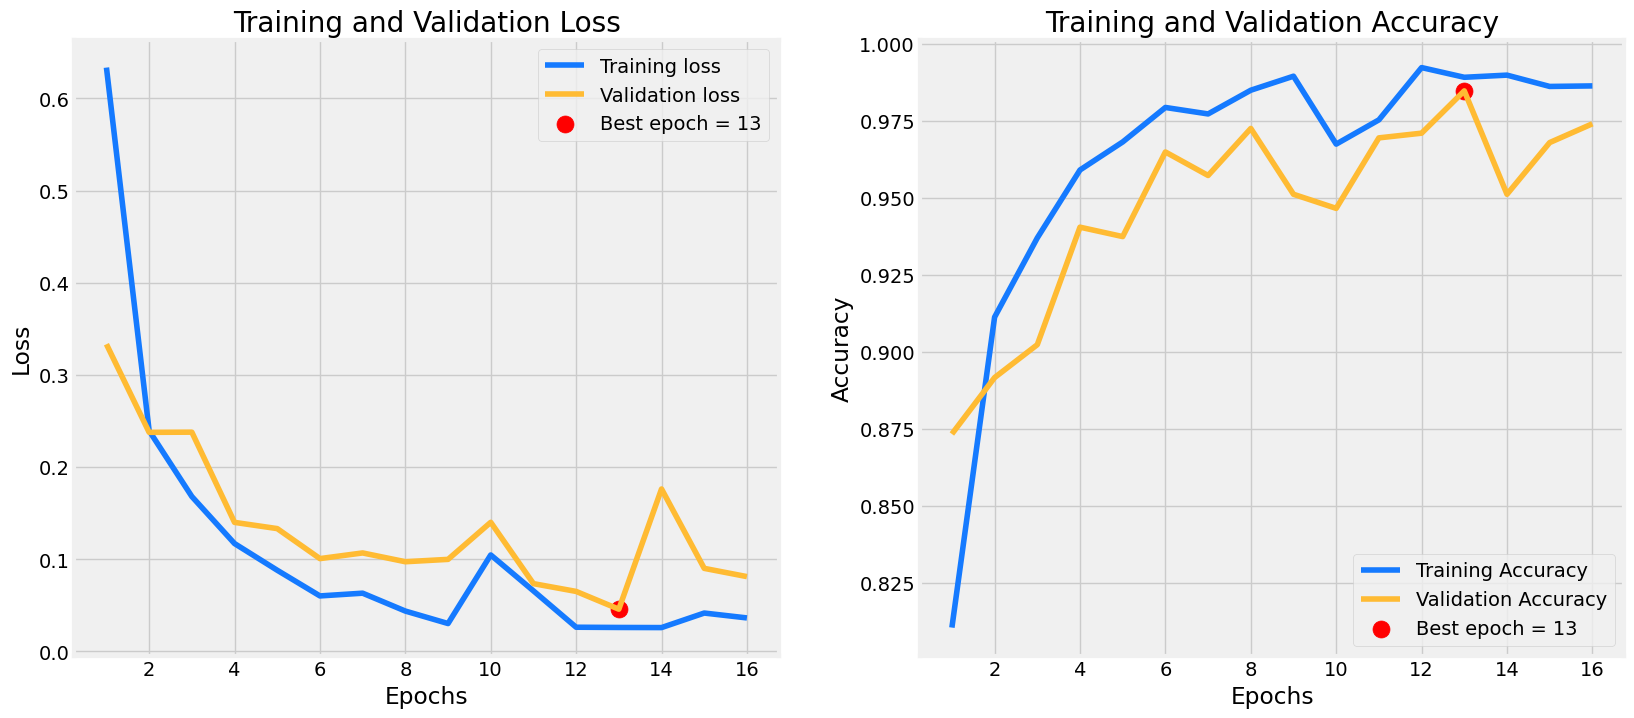

In [18]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'

plt.figure(figsize = (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, color = '#157AFF', label = 'Training loss')
plt.plot(Epochs, val_loss, color = '#FFBB33', label = 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s = 150, color = 'red', label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, color = '#157AFF', label = 'Training Accuracy')
plt.plot(Epochs, val_acc, color = '#FFBB33', label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s = 150, color = 'red', label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

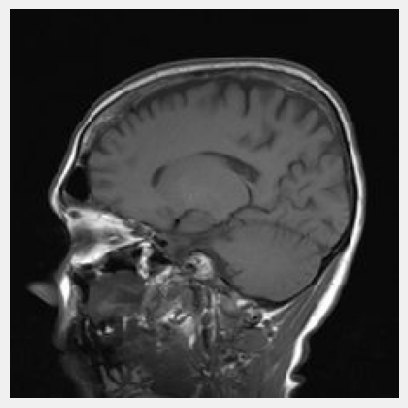

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
Predicted label: notumor | Actual label: notumor


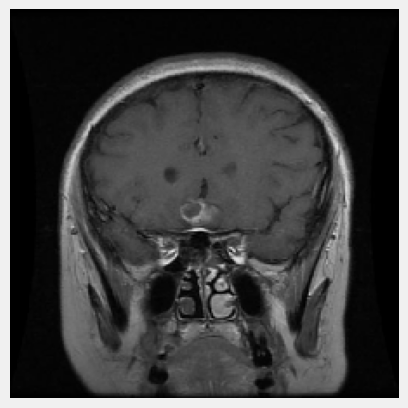

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
Predicted label: pituitary | Actual label: pituitary


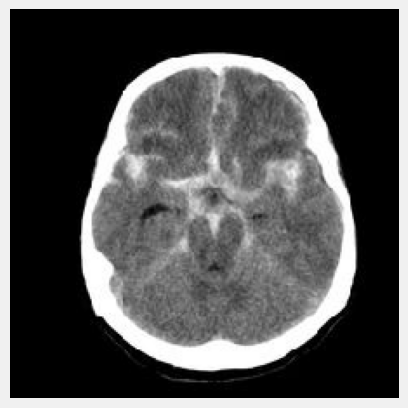

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
Predicted label: notumor | Actual label: notumor


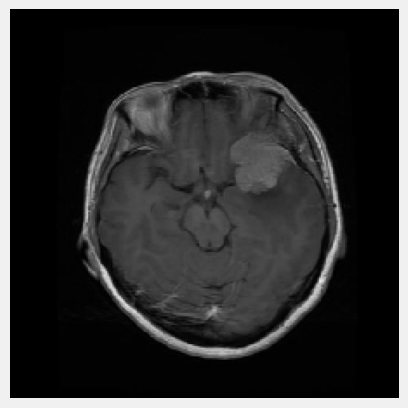

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
Predicted label: meningioma | Actual label: meningioma


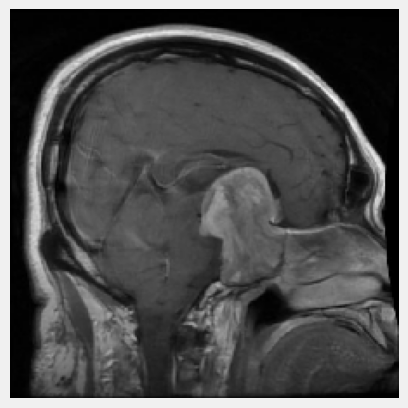

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
Predicted label: pituitary | Actual label: pituitary


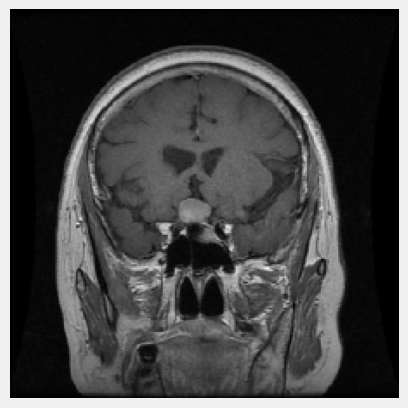

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
Predicted label: pituitary | Actual label: pituitary


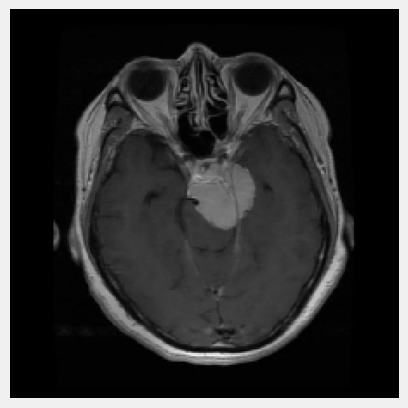

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
Predicted label: meningioma | Actual label: meningioma


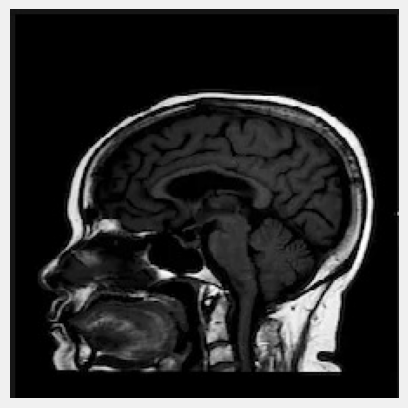

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
Predicted label: notumor | Actual label: notumor


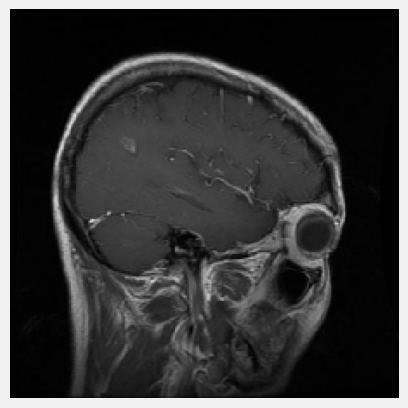

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
Predicted label: glioma | Actual label: glioma


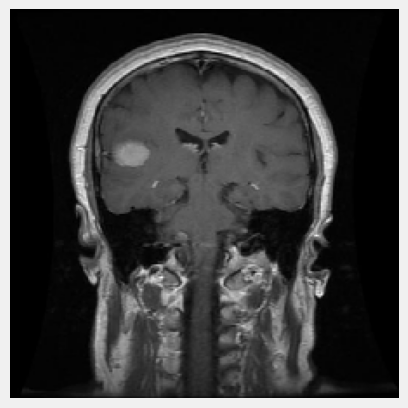

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
Predicted label: meningioma | Actual label: meningioma


In [37]:
image, labels = next(test_gen)

for i in range(10):
    plt.imshow(image[i].astype('uint8'))  # Ensure the image is in uint8 format
    plt.axis('off')  # Turn off axis
    plt.show()  # Display the image
    
    prediction = np.argmax(model2.predict(image[i][np.newaxis, ...]))
    actual_label_index = np.argmax(labels[i])  # Convert one-hot encoded label to index
    print(f"Predicted label: {class_names[prediction]} | Actual label: {class_names[actual_label_index]}")


In [44]:
loss,acc = model2.evaluate(test_gen)

11/11 ━━━━━━━━━━━━━━━━━━━━ 53s 5s/step - accuracy: 0.9742 - loss: 0.0711


11/11 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step


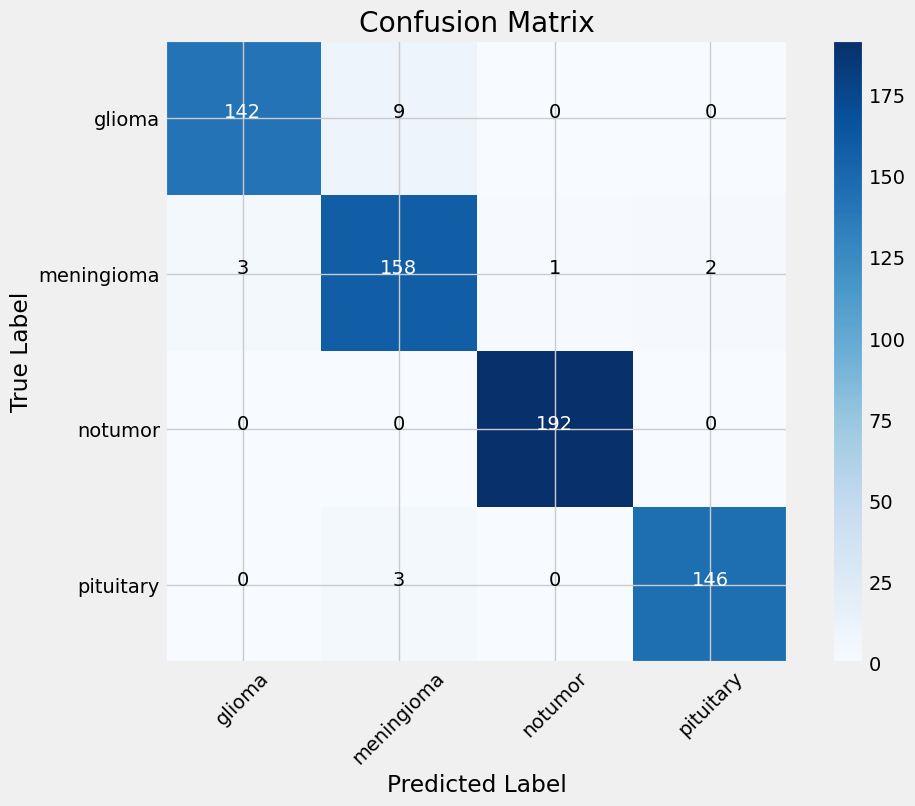

In [45]:
import itertools

# Generate predictions for the test data
predictions = model2.predict(test_gen)

class_names = list(test_gen.class_indices.keys())
images, labels = next(test_gen)

# Extract the predicted labels from the predictions
predicted_labels = np.argmax(predictions, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(test_gen.classes, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [93]:
y_true_model2 = test_gen.classes
y_pred2 = model2.predict(test_gen)

# Print the classification report
print(classification_report(y_true_model2, np.argmax(y_pred2, axis=1), target_names=classes))

11/11 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step
              precision    recall  f1-score   support

      glioma       0.98      0.94      0.96       151
  meningioma       0.93      0.96      0.95       164
     notumor       0.99      1.00      1.00       192
   pituitary       0.99      0.98      0.98       149

    accuracy                           0.97       656
   macro avg       0.97      0.97      0.97       656
weighted avg       0.97      0.97      0.97       656



In [61]:
from keras.preprocessing import image

# Load and preprocess the new image
img_path = 'C:/Users/Venkatesh/Downloads/test02.jpeg'
img = image.load_img(img_path, target_size=(224, 224))  # Resize to match input size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Rescale pixel values

# Make predictions with your trained model
predictions = model2.predict(img_array)

# Interpret predictions
predicted_class = np.argmax(predictions)
class_name = class_names[predicted_class]

print("Predicted Class:", class_name)
print("Predicted Probabilities:", predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
Predicted Class: glioma
Predicted Probabilities: [[0.6745709  0.15714711 0.08361677 0.08466522]]


## InceptionV3

In [23]:
# Load the pre-trained InceptionV3 model
from tensorflow.keras.applications import InceptionV3
pre_trained_model = InceptionV3(input_shape=(224, 224, 3), 
                                include_top=False, 
                                weights='imagenet')

# Freeze all layers of the pre-trained model
for layer in pre_trained_model.layers:
    layer.trainable = False

num_classes = 4

x = GlobalAveragePooling2D()(pre_trained_model.output)
x = Dense(128, activation='relu')(x)  
x = Dense(64, activation='relu')(x)   
predictions = Dense(num_classes, activation='softmax')(x)  # 4 classes for brain tumor classification


model3 = Model(inputs=pre_trained_model.input, outputs=predictions)

# Compile the model
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model3.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 111, 111, 32)      │             864 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 111, 111, 32)      │              96 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 111, 111, 32)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 109, 109, 32)      │           9,216 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 109, 109, 32)      │              96 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 109, 109, 32)      │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 109, 109, 64)      │          18,432 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 109, 109, 64)      │             192 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 109, 109, 64)      │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 54, 54, 64)        │               0 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 54, 54, 80)        │           5,120 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 54, 54, 80)        │             240 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 54, 54, 80)        │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 52, 52, 192)       │         138,240 │ activation_3[0][0]         │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 22,073,572 (84.20 MB)

 Trainable params: 270,788 (1.03 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss',  
                               patience=3,          # Number of epochs with no improvement after which training will be stopped
                               restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
                               verbose=1)  

model3.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy']
                   )

history = model3.fit(train_gen, epochs=30, validation_data=valid_gen,callbacks=early_stopping)

Epoch 1/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.4601 - loss: 4.0121 - val_accuracy: 0.6473 - val_loss: 0.9321
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.7299 - loss: 0.7193 - val_accuracy: 0.7618 - val_loss: 0.6041
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.7688 - loss: 0.5833 - val_accuracy: 0.7649 - val_loss: 0.5504
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.7897 - loss: 0.5335 - val_accuracy: 0.7771 - val_loss: 0.4984
Epoch 5/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.8158 - loss: 0.4916 - val_accuracy: 0.8183 - val_loss: 0.4175
Epoch 6/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.8363 - loss: 0.4214 - val_accuracy: 0.7863 - val_loss: 0.4860
Epoch 7/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.8445 - loss: 0.3987 - val_accuracy: 0.8366 - val_loss: 0.3744
Epoch 8/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.8625 - loss: 0.3675 - val_accuracy: 0.8076 - v

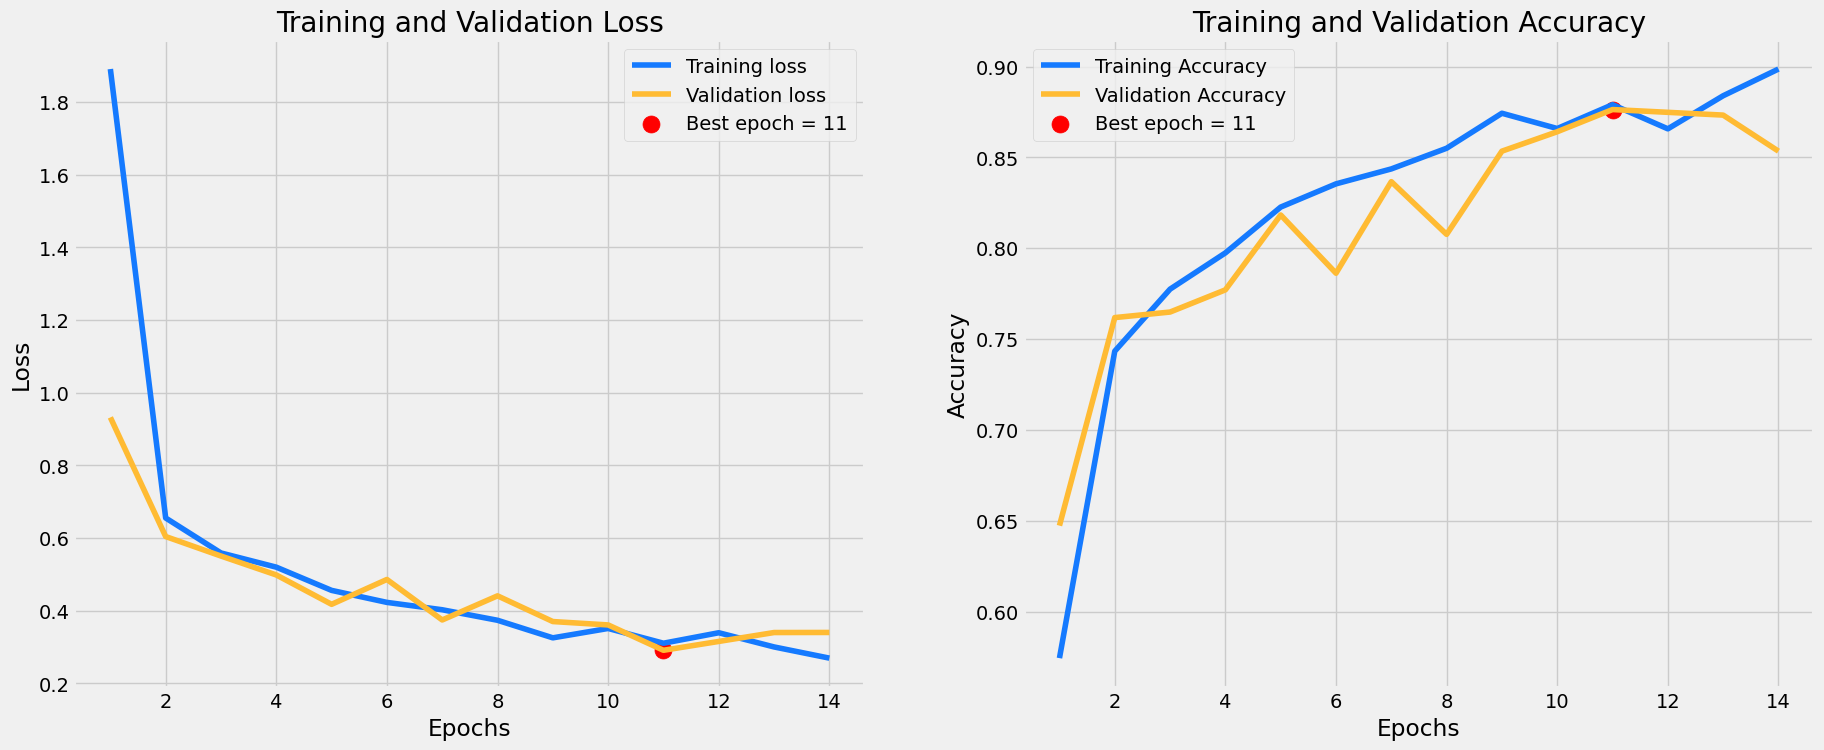

In [25]:
#Graph results
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'

plt.figure(figsize = (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, color = '#157AFF', label = 'Training loss')
plt.plot(Epochs, val_loss, color = '#FFBB33', label = 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s = 150, color = 'red', label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, color = '#157AFF', label = 'Training Accuracy')
plt.plot(Epochs, val_acc, color = '#FFBB33', label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s = 150, color = 'red', label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [27]:
loss,acc = model3.evaluate(test_gen)

C:\Users\Venkatesh\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8476 - loss: 0.3871


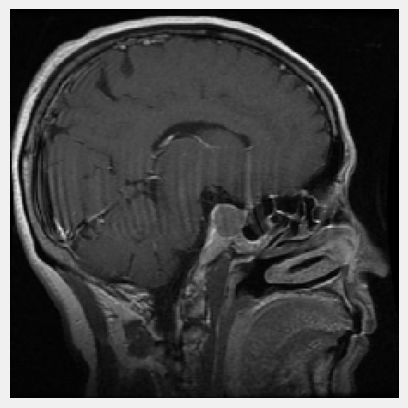

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step
Predicted label: pituitary | Actual label: pituitary


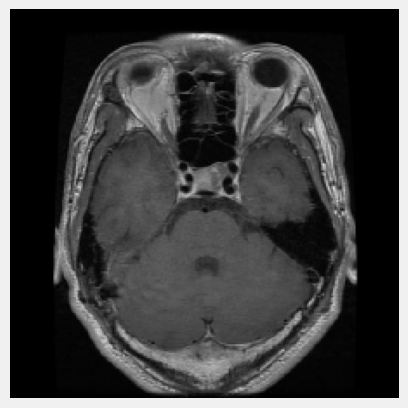

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Predicted label: meningioma | Actual label: pituitary


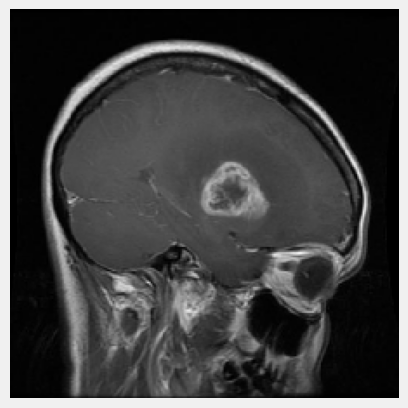

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Predicted label: glioma | Actual label: glioma


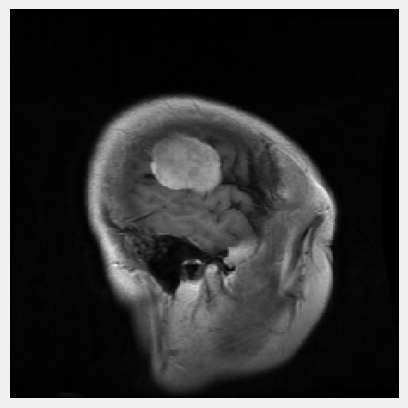

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Predicted label: glioma | Actual label: meningioma


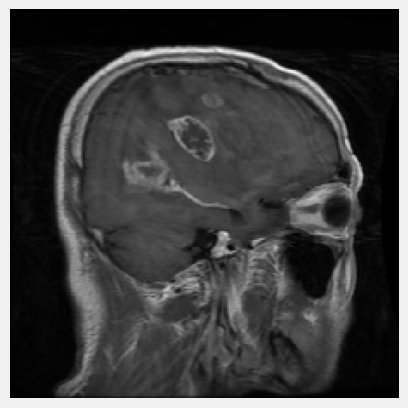

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Predicted label: meningioma | Actual label: glioma


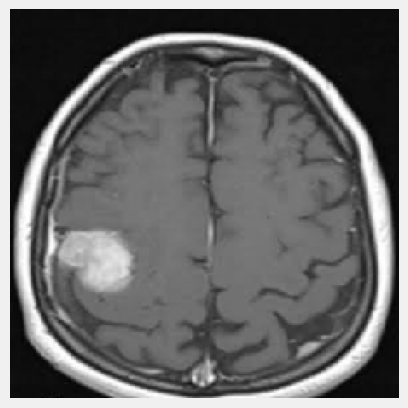

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Predicted label: meningioma | Actual label: meningioma


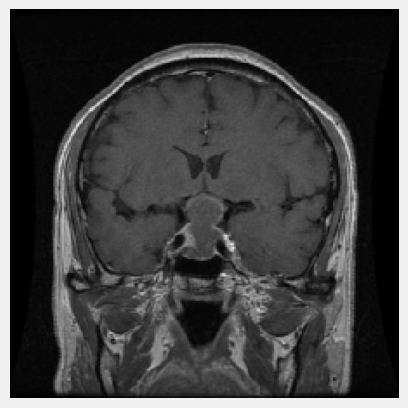

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Predicted label: pituitary | Actual label: pituitary


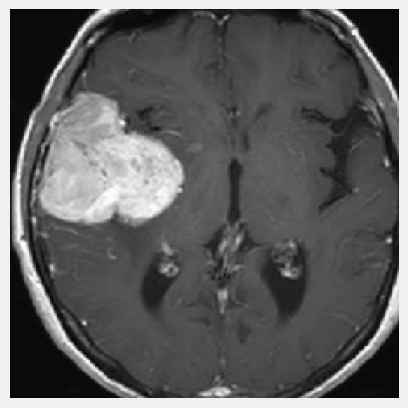

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Predicted label: meningioma | Actual label: meningioma


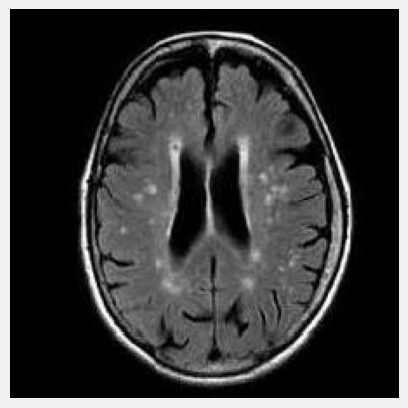

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Predicted label: notumor | Actual label: notumor


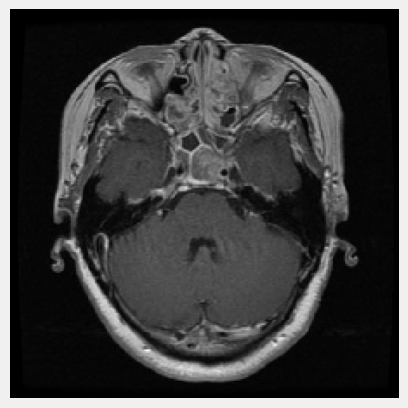

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Predicted label: pituitary | Actual label: pituitary


In [36]:
image, labels = next(test_gen)

for i in range(10):
    plt.imshow(image[i].astype('uint8'))  # Ensure the image is in uint8 format
    plt.axis('off')  # Turn off axis
    plt.show()  # Display the image
    
    prediction = np.argmax(model3.predict(image[i][np.newaxis, ...]))
    actual_label_index = np.argmax(labels[i])  # Convert one-hot encoded label to index
    print(f"Predicted label: {class_names[prediction]} | Actual label: {class_names[actual_label_index]}")


11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step


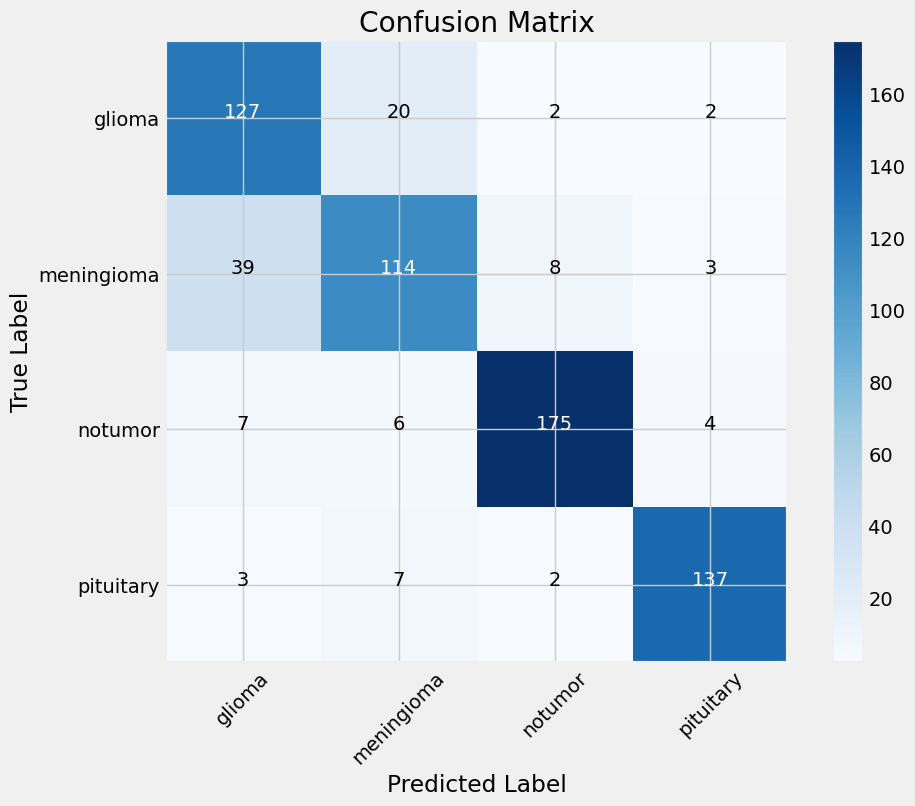

In [43]:
import itertools

# Generate predictions for the test data
predictions = model3.predict(test_gen)

class_names = list(test_gen.class_indices.keys())
images, labels = next(test_gen)

# Extract the predicted labels from the predictions
predicted_labels = np.argmax(predictions, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(test_gen.classes, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [89]:
y_true_model3 = test_gen.classes
y_pred3 = model3.predict(test_gen)

# Print the classification report
print(classification_report(y_true_model3, np.argmax(y_pred3, axis=1), target_names=classes))


11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step
              precision    recall  f1-score   support

      glioma       0.72      0.84      0.78       151
  meningioma       0.78      0.70      0.73       164
     notumor       0.94      0.91      0.92       192
   pituitary       0.94      0.92      0.93       149

    accuracy                           0.84       656
   macro avg       0.84      0.84      0.84       656
weighted avg       0.85      0.84      0.84       656



In [62]:
from keras.preprocessing import image

# Load and preprocess the new image
img_path = 'C:/Users/Venkatesh/Downloads/test02.jpeg'
img = image.load_img(img_path, target_size=(224, 224))  # Resize to match input size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Rescale pixel values

# Make predictions with your trained model
predictions = model3.predict(img_array)

# Interpret predictions
predicted_class = np.argmax(predictions)
class_name = class_names[predicted_class]

print("Predicted Class:", class_name)
print("Predicted Probabilities:", predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Predicted Class: pituitary
Predicted Probabilities: [[0.22795625 0.26353702 0.15791385 0.35059282]]


## Resnet101

In [34]:
from keras.applications import ResNet101

# Load ResNet101 model without the top (fully connected) layers
resnet = ResNet101(weights='imagenet', 
                   include_top=False, 
                   input_shape=(img_rows, img_cols, 3))

# Freeze all layers in ResNet101
for layer in resnet.layers:
    layer.trainable = False

# Define custom head for the model
def build_custom_head(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = Dense(128, activation='relu')(top_model)
    top_model = Dense(num_classes, activation='softmax')(top_model)
    return top_model

# Define number of classes
num_classes = 4  # Change this to the desired number of classes

# Build custom head for the model with 4 output classes
FC_Head = build_custom_head(resnet, num_classes)

# Create final model
model4 = Model(inputs=resnet.input, outputs=FC_Head)

# Print model summary
print(model4.summary())


171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 95s 1us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 45,347,332 (172.99 MB)

 Trainable params: 2,689,156 (10.26 MB)

 Non-trainable params: 42,658,176 (162.73 MB)

None


In [35]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss',  
                               patience=3,          # Number of epochs with no improvement after which training will be stopped
                               restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
                               verbose=1)  

model4.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy']
                   )

history = model4.fit(train_gen, epochs=30, validation_data=valid_gen,callbacks=early_stopping)

Epoch 1/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 504s 5s/step - accuracy: 0.6705 - loss: 0.9541 - val_accuracy: 0.8809 - val_loss: 0.2846
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 490s 5s/step - accuracy: 0.9154 - loss: 0.2333 - val_accuracy: 0.9099 - val_loss: 0.2336
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 4701s 53s/step - accuracy: 0.9430 - loss: 0.1519 - val_accuracy: 0.9496 - val_loss: 0.1339
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 465s 5s/step - accuracy: 0.9453 - loss: 0.1345 - val_accuracy: 0.9328 - val_loss: 0.1558
Epoch 5/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 468s 5s/step - accuracy: 0.9526 - loss: 0.1081 - val_accuracy: 0.9374 - val_loss: 0.1533
Epoch 6/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 460s 5s/step - accuracy: 0.9634 - loss: 0.0986 - val_accuracy: 0.9588 - val_loss: 0.1199
Epoch 7/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 460s 5s/step - accuracy: 0.9722 - loss: 0.0706 - val_accuracy: 0.9603 - val_loss: 0.1301
Epoch 8/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 467s 5s/step - accuracy: 0.9792 - loss: 0.0603 - val_accuracy: 0.9634 -

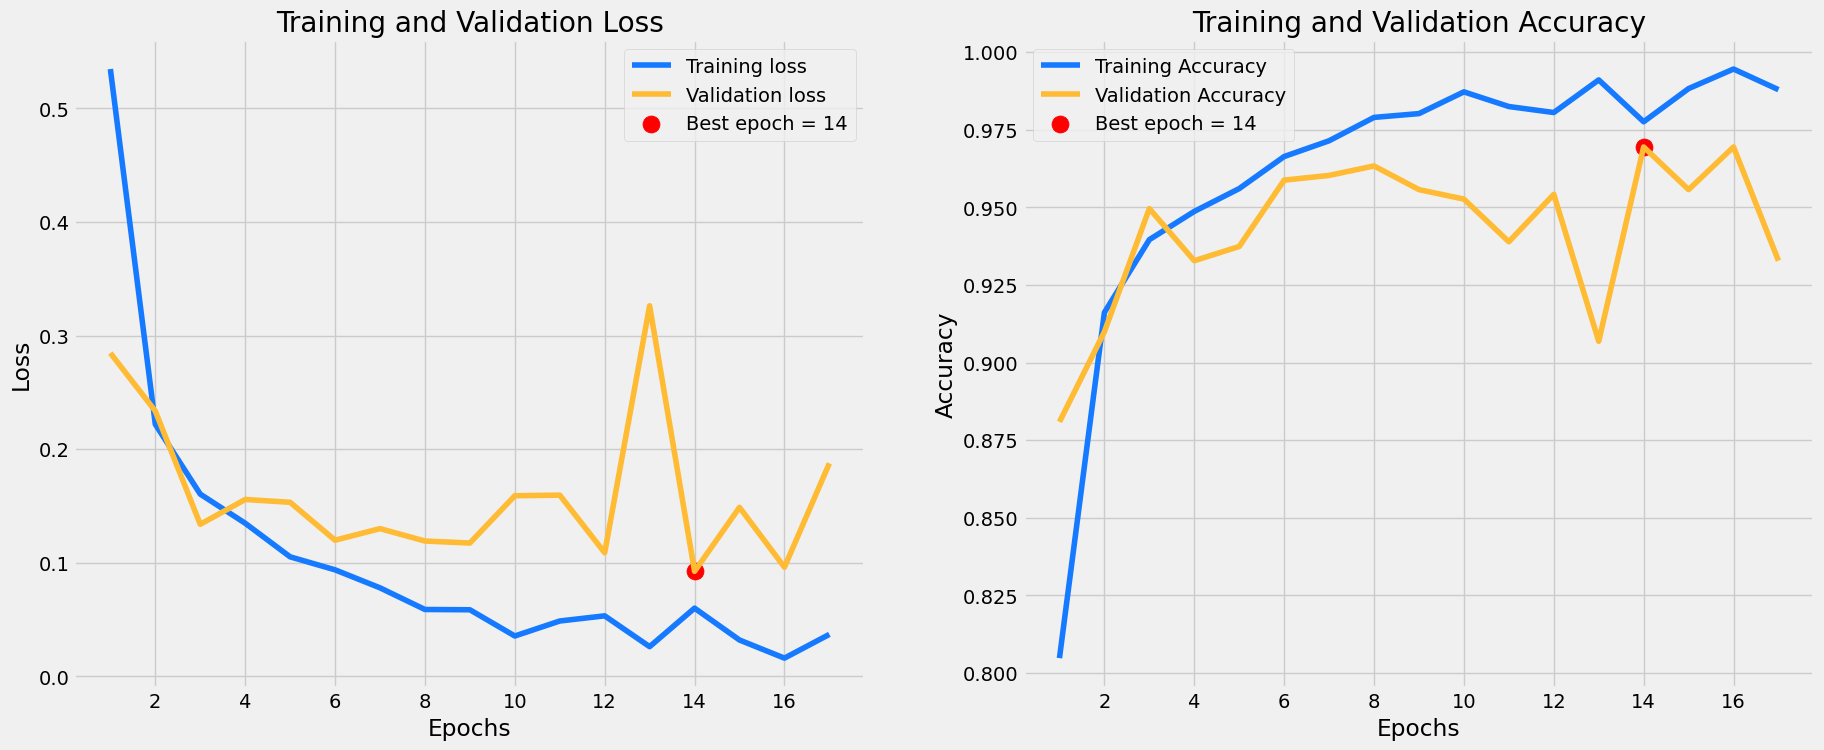

In [38]:
#Graph results
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'

plt.figure(figsize = (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, color = '#157AFF', label = 'Training loss')
plt.plot(Epochs, val_loss, color = '#FFBB33', label = 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s = 150, color = 'red', label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, color = '#157AFF', label = 'Training Accuracy')
plt.plot(Epochs, val_acc, color = '#FFBB33', label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s = 150, color = 'red', label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [40]:
loss,acc = model4.evaluate(test_gen)

11/11 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - accuracy: 0.9503 - loss: 0.1502


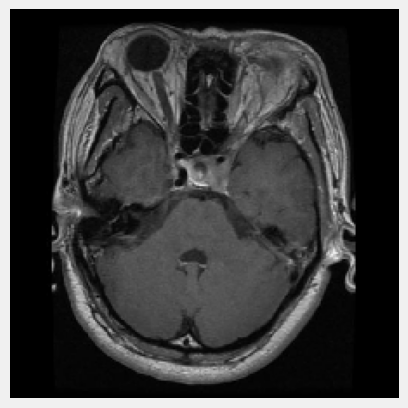

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predicted label: pituitary | Actual label: pituitary


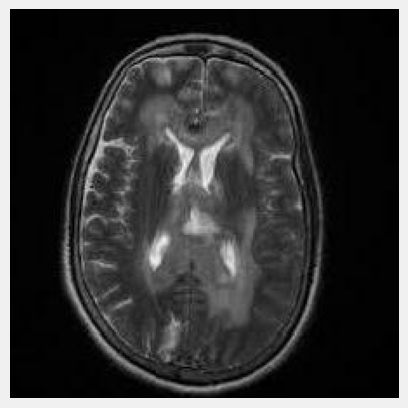

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
Predicted label: notumor | Actual label: notumor


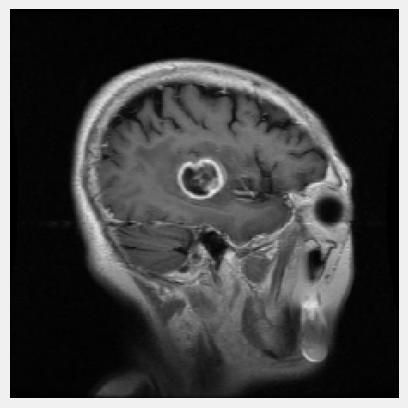

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
Predicted label: glioma | Actual label: glioma


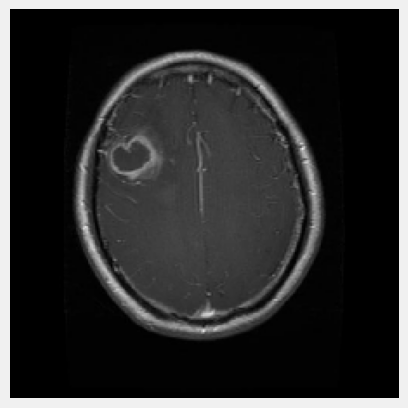

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
Predicted label: glioma | Actual label: glioma


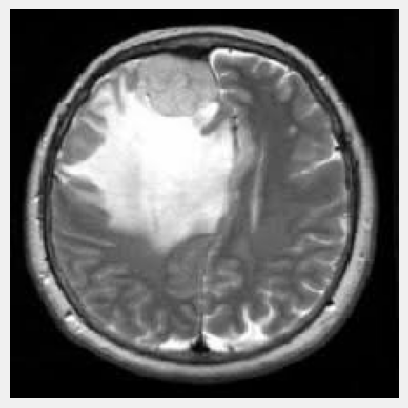

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
Predicted label: meningioma | Actual label: meningioma


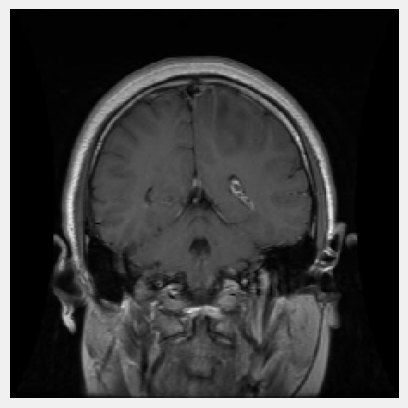

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
Predicted label: meningioma | Actual label: glioma


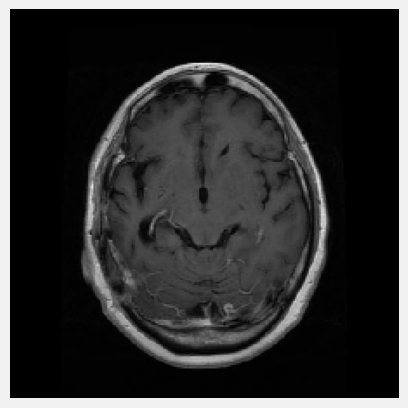

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
Predicted label: glioma | Actual label: glioma


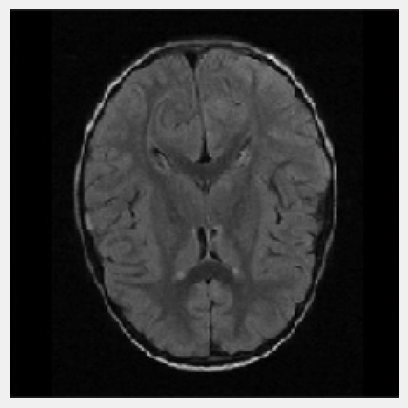

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
Predicted label: notumor | Actual label: notumor


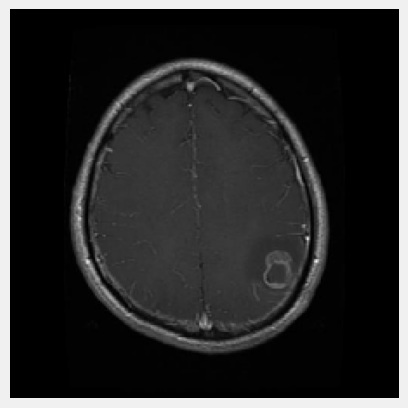

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
Predicted label: glioma | Actual label: glioma


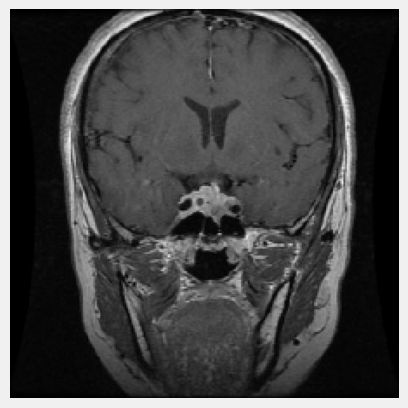

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
Predicted label: pituitary | Actual label: pituitary


In [41]:
image, labels = next(test_gen)

for i in range(10):
    plt.imshow(image[i].astype('uint8'))  # Ensure the image is in uint8 format
    plt.axis('off')  # Turn off axis
    plt.show()  # Display the image
    
    prediction = np.argmax(model4.predict(image[i][np.newaxis, ...]))
    actual_label_index = np.argmax(labels[i])  # Convert one-hot encoded label to index
    print(f"Predicted label: {class_names[prediction]} | Actual label: {class_names[actual_label_index]}")


11/11 ━━━━━━━━━━━━━━━━━━━━ 60s 5s/step


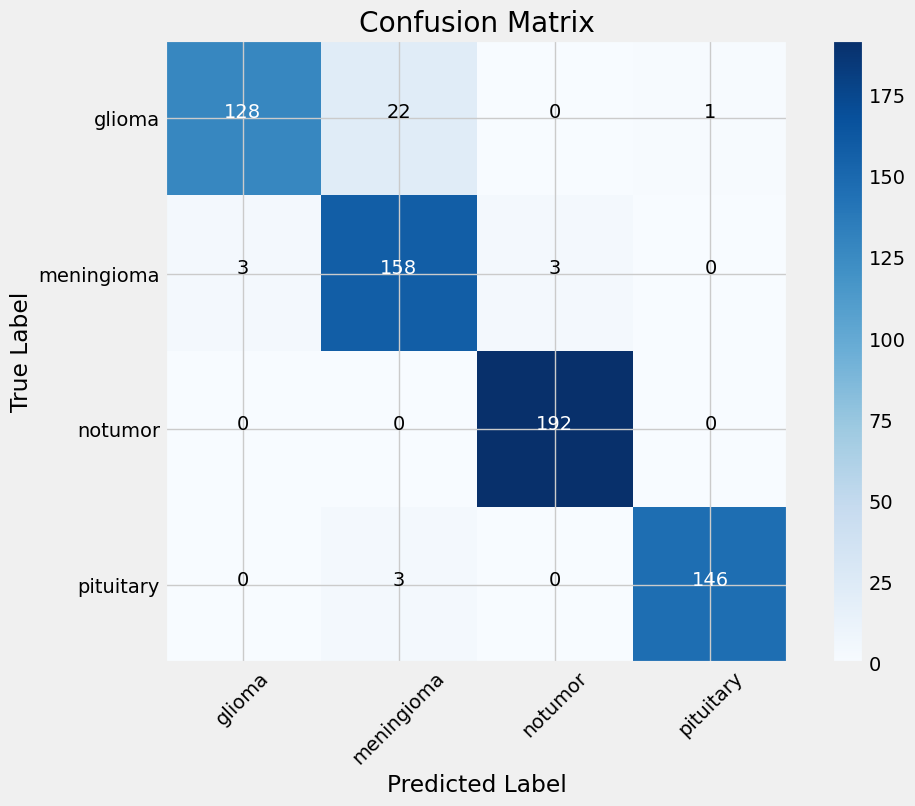

In [46]:
import itertools

# Generate predictions for the test data
predictions = model4.predict(test_gen)

class_names = list(test_gen.class_indices.keys())
images, labels = next(test_gen)

# Extract the predicted labels from the predictions
predicted_labels = np.argmax(predictions, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(test_gen.classes, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [88]:
y_true_model4 = test_gen.classes

y_pred4 = model4.predict(test_gen)

# Print the classification report
print(classification_report(y_true_model4, np.argmax(y_pred4, axis=1), target_names=classes))


11/11 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step
              precision    recall  f1-score   support

      glioma       0.98      0.85      0.91       151
  meningioma       0.86      0.96      0.91       164
     notumor       0.98      1.00      0.99       192
   pituitary       0.99      0.98      0.99       149

    accuracy                           0.95       656
   macro avg       0.95      0.95      0.95       656
weighted avg       0.95      0.95      0.95       656



In [63]:
from keras.preprocessing import image

# Load and preprocess the new image
img_path = 'C:/Users/Venkatesh/Downloads/test02.jpeg'
img = image.load_img(img_path, target_size=(224, 224))  # Resize to match input size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Rescale pixel values

# Make predictions with your trained model
predictions = model4.predict(img_array)

# Interpret predictions
predicted_class = np.argmax(predictions)
class_name = class_names[predicted_class]

print("Predicted Class:", class_name)
print("Predicted Probabilities:", predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Predicted Class: glioma
Predicted Probabilities: [[9.5231462e-01 4.4132173e-02 3.5439883e-03 9.1456768e-06]]


## Comparison Of Models

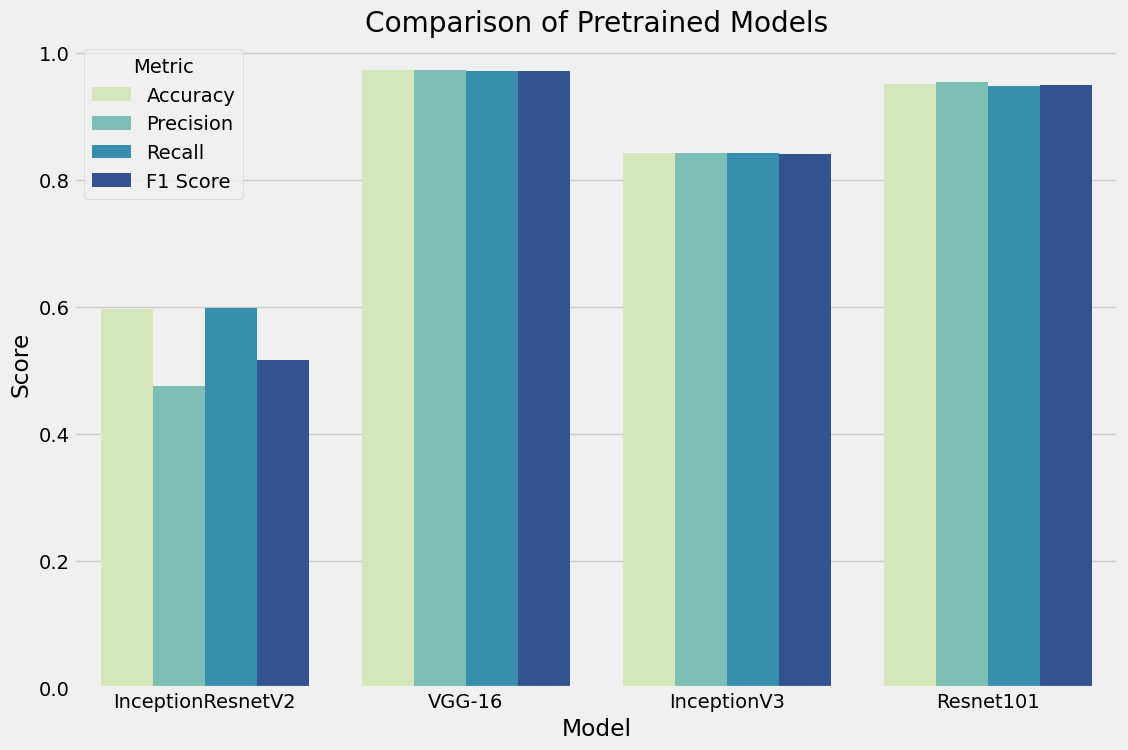

In [122]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Example classification report (replace this with your actual classification reports)
classification_report_model1 = classification_report(y_true_model1, np.argmax(y_pred1, axis=1), output_dict=True)
classification_report_model2 = classification_report(y_true_model2, np.argmax(y_pred2, axis=1), output_dict=True)
classification_report_model3 = classification_report(y_true_model3, np.argmax(y_pred3, axis=1), output_dict=True)
classification_report_model4 = classification_report(y_true_model4, np.argmax(y_pred4, axis=1), output_dict=True)

# Calculate accuracy scores
accuracy_model1 = accuracy_score(y_true_model1, np.argmax(y_pred1, axis=1))
accuracy_model2 = accuracy_score(y_true_model2, np.argmax(y_pred2, axis=1))
accuracy_model3 = accuracy_score(y_true_model3, np.argmax(y_pred3, axis=1))
accuracy_model4 = accuracy_score(y_true_model4, np.argmax(y_pred4, axis=1))

# Extract precision, recall, and f1-score from classification report
precision_model1 = classification_report_model1['macro avg']['precision']
precision_model2 = classification_report_model2['macro avg']['precision']
precision_model3 = classification_report_model3['macro avg']['precision']
precision_model4 = classification_report_model4['macro avg']['precision']

recall_model1 = classification_report_model1['macro avg']['recall']
recall_model2 = classification_report_model2['macro avg']['recall']
recall_model3 = classification_report_model3['macro avg']['recall']
recall_model4 = classification_report_model4['macro avg']['recall']

f1_score_model1 = classification_report_model1['macro avg']['f1-score']
f1_score_model2 = classification_report_model2['macro avg']['f1-score']
f1_score_model3 = classification_report_model3['macro avg']['f1-score']
f1_score_model4 = classification_report_model4['macro avg']['f1-score']

# Create a DataFrame to store the model evaluation results
model_results = pd.DataFrame({
    'Model': ['InceptionResnetV2', 'VGG-16', 'InceptionV3', 'Resnet101'],
    'Accuracy': [accuracy_model1, accuracy_model2, accuracy_model3, accuracy_model4],
    'Precision': [precision_model1, precision_model2, precision_model3, precision_model4],
    'Recall': [recall_model1, recall_model2, recall_model3, recall_model4],
    'F1 Score': [f1_score_model1, f1_score_model2, f1_score_model3, f1_score_model4]
})

# Melt the DataFrame to 'long' format for visualization
model_results_melted = pd.melt(model_results, id_vars=['Model'], var_name='Metric', value_name='Score')

# Plot using Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(data=model_results_melted, x='Model', y='Score', hue='Metric', palette='YlGnBu')
plt.title('Comparison of Pretrained Models')
plt.xlabel('Model')
plt.ylabel('Score')
plt.legend(title='Metric')
plt.show()
